In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# The url for book crossing (BX) dataset is notavailable, use the downloades zip from:
# https://www.kaggle.com/datasets/somnambwl/bookcrossing-dataset?resource=download
!unzip archive.zip

Archive:  archive.zip
  inflating: Books.csv               
  inflating: Ratings.csv             
  inflating: Users.csv               


In [3]:
import pandas as pd

ratings = pd.read_csv('Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('Books.csv', sep=';', encoding='latin-1')

<ipython-input-3-7997f032d7b7>:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')


In [4]:
ratings

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [5]:
users # no location column

,User-ID,Age
0,1,NaN
1,2,18
2,3,NaN
3,4,17
4,5,NaN
...,...,...
278854,278854,NaN
278855,278855,50
278856,278856,NaN
278857,278857,NaN


In [6]:
books

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company
...,...,...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271375,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271377,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


<Axes: xlabel='Rating', ylabel='count'>

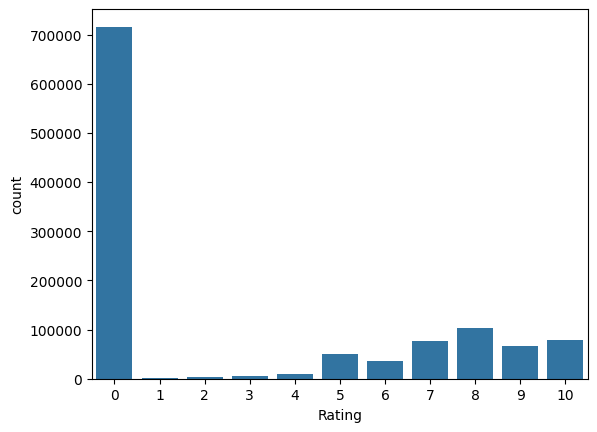

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x=ratings['Rating'])

Rating distribution (interaction with a book is represented as
a rating of zero, while ratings between 1 and 10 are real ratings

In [8]:
print(len(ratings['User-ID'].unique()))
print(len(ratings['ISBN'].unique()))

105283
340556


Text(0, 0.5, 'Count')

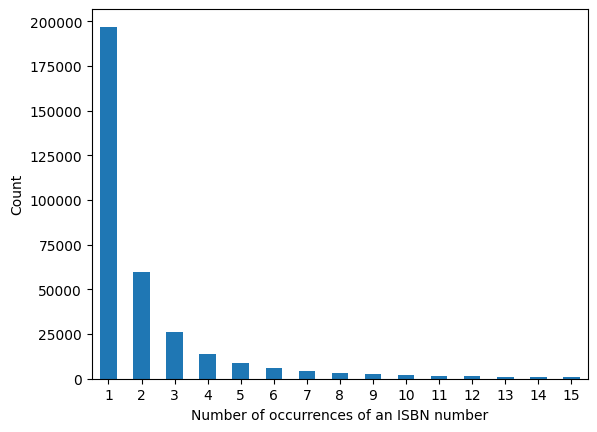

In [9]:
isbn_counts = ratings.groupby('ISBN').size()
count_occurrences = isbn_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel("Number of occurrences of an ISBN number")
plt.ylabel("Count")

A lot of books have only been rated once or twice. It is very rare to see books with
a lot of ratings

Text(0, 0.5, 'Count')

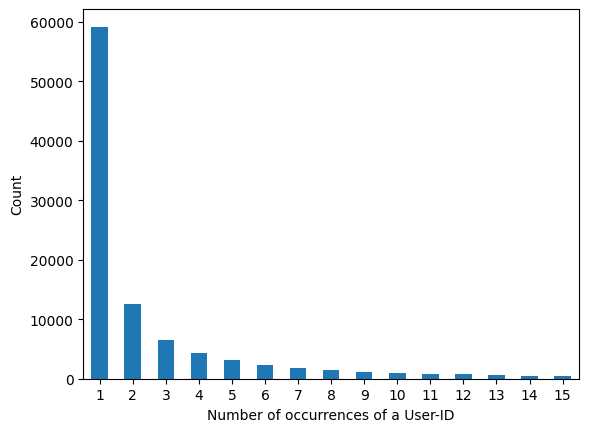

In [10]:
userid_counts = ratings.groupby('User-ID').size()
count_occurrences = userid_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel("Number of occurrences of a User-ID")
plt.ylabel("Count")

This also means that most users only rate one or two books, but a few of them rate a lot of books

## Preprocessing the Book-Crossing dataset

With the use of collaborative **filtering approach**. Collaborative filtering is a technique used to make personalized
recommendations to users. It is based on the idea that users who have similar preferences or behaviors
are more likely to have similar interests. Collaborative filtering algorithms use this information to
identify patterns and make recommendations to users based on the preferences of similar users.

This is different from **content-based filtering**, which is a recommendation approach that relies on
the features of the items being recommended. It generates recommendations by identifying the
characteristics of an item and matching them to the characteristics of other items that have been liked
by the user in the past. Content-based filtering approaches are typically based on the idea that if a
user likes an item with certain characteristics, they will also like items with similar characteristics

In this chapter, we will focus on collaborative filtering. Our objective is to determine which book to
recommend to a user based on the preferences of other users.

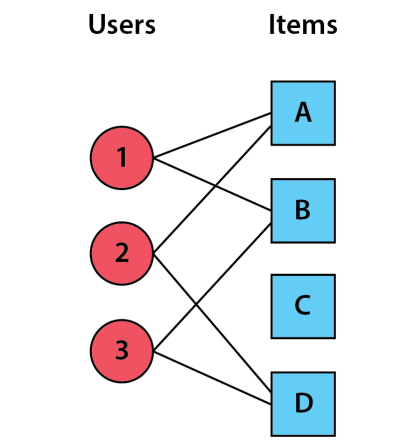

Knowing that **User 1** liked items **A** and **B**, and **User 3** liked items **B** and **D**, we should probably
recommend item **B** to **User 2**, who also enjoyed items **A** and **D**.

This is the type of graph we want to build from the Book-Crossing dataset. More precisely, we
also want to include negative samples. In this context, negative samples refer to items that have not
been rated by a given user. Items that have been rated by a particular user are also referred to as
positive items.

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [12]:
df = pd.read_csv('Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('Books.csv', sep=';', encoding='latin-1')

<ipython-input-12-2215e05d5396>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')


In [13]:
# Preprocessing
# Keep rows where ISBN information can be found in the books DataFrame and
# User-ID information can be found in the users DataFrame
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep only high ratings (>= 8/10) the 100k highest ratings to speed up the training
df = df[df['Rating'] >= 8].iloc[:100000]

In [14]:
# Create mappings from user and item identifiers to integer indices
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}


In [15]:
# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

In [16]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [17]:
user_ids

tensor([    0,     1,     2,  ..., 19556, 19556, 19556])

In [18]:
item_ids

tensor([    0,     1,     2,  ..., 56910, 56911, 56912])

In [19]:
edge_index

tensor([[    0,     1,     2,  ..., 19556, 19556, 19556],
        [    0,     1,     2,  ..., 56910, 56911, 56912]])

In [20]:
# train, val, and test splits (80/10/10)
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=42)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

In [21]:
train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [22]:
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)

    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]

    return user_index, pos_item_index, neg_item_index

# LightGCN

In [23]:
class LightGCN(nn.Module):
  def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
    super().__init__()
    self.num_users = num_users
    self.num_items = num_items
    self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
    self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

    self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

    nn.init.normal_(self.emb_users.weight, std=0.01)
    nn.init.normal_(self.emb_items.weight, std=0.01)

  def forward(self, edge_index):
    emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
    embs = [emb]

    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    emb_final = torch.mean(torch.stack(embs, dim=1), dim=1)
    emb_users_final, emb_items_final = torch.split(emb_final,
                                                   [self.num_users, self.num_items])

    return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [24]:
model = LightGCN(num_users, num_items)
model

LightGCN(
  (emb_users): Embedding(19557, 64)
  (emb_items): Embedding(56913, 64)
  (convs): ModuleList(
    (0-3): 4 x LGConv()
  )
)

LightGCN architecture employs Bayesian
Personalized Ranking (BPR) loss, which optimizes the model’s ability to rank positive items higher
than negative items for a given user. It is implemented as follows:
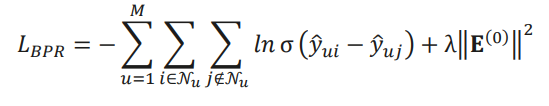


In [25]:
# BPR Loss function
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
  reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                       emb_pos_items.norm().pow(2) +
                       emb_neg_items.norm().pow(2))

  pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
  neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

  bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
  # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

  return -bpr_loss + reg_loss

In [26]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [27]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [28]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1

    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.

    return np.mean(ndcg)

In [29]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [30]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

# Training

In [31]:
K = 10
LAMBDA = 1e-7 # 1e-6
BATCH_SIZE = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
%%time

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)

        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f'Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | '
        f'Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}')

Epoch 0 | Train loss: -0.70342 | Val loss: -0.69316 | Val recall@10: 0.00958 | Val ndcg@10: 0.00625
Epoch 5 | Train loss: -3.89316 | Val loss: -0.70439 | Val recall@10: 0.01184 | Val ndcg@10: 0.00700
Epoch 10 | Train loss: -13.44911 | Val loss: -0.76730 | Val recall@10: 0.01164 | Val ndcg@10: 0.00693
Epoch 15 | Train loss: -28.93671 | Val loss: -0.91426 | Val recall@10: 0.01251 | Val ndcg@10: 0.00716
Epoch 20 | Train loss: -42.36901 | Val loss: -1.14686 | Val recall@10: 0.01179 | Val ndcg@10: 0.00691
Epoch 25 | Train loss: -72.77132 | Val loss: -1.43653 | Val recall@10: 0.01179 | Val ndcg@10: 0.00698
Epoch 30 | Train loss: -91.27440 | Val loss: -1.82463 | Val recall@10: 0.01202 | Val ndcg@10: 0.00704
CPU times: user 20min 40s, sys: 6min 10s, total: 26min 50s
Wall time: 27min 3s


In [33]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f'Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}')

Test loss: -1.81852 | Test recall@10: 0.01293 | Test ndcg@10: 0.00736


We obtain a recall@10 value of 0.0129 and an ndcg@10 value of 0.0074, which is close
to the results obtained by the authors of LightGCN on other datasets.

# Get recommendations for a given user

These recommendations cannot be
books the user has already rated (it cannot be a positive item).

In [34]:
bookid_title = pd.Series(books['Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

In [35]:
from PIL import Image
import requests

def recommend(user_id, num_recs):
  user = user_mapping[user_id]
  emb_user = model.emb_users.weight[user]
  ratings = model.emb_items.weight @ emb_user

  values, indices = torch.topk(ratings, k=100)

  ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
  item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
  titles = [bookid_title[id] for id in item_isbns]
  authors = [bookid_author[id] for id in item_isbns]

  print(f'Favorite books from user n°{user_id}:')
  for i in range(len(item_isbns)):
    print(f'- {titles[i]}, by {authors[i]}')

  ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
  item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
  titles = [bookid_title[id] for id in item_isbns]
  authors = [bookid_author[id] for id in item_isbns]

  print(f'\nRecommended books for user n°{user_id}')
  for i in range(num_recs):
    print(f'- {titles[i]}, by {authors[i]}')

In [36]:
recommend(user_id=6332, num_recs=5)

Favorite books from user n°6332:

Recommended books for user n°6332
- The Lovely Bones: A Novel, by Alice Sebold
- The Secret Life of Bees, by Sue Monk Kidd
- Where the Heart Is (Oprah's Book Club (Paperback)), by Billie Letts
- The Da Vinci Code, by Dan Brown
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling


In [37]:
recommend(user_id=12, num_recs=5)

Favorite books from user n°12:

Recommended books for user n°12
- The Lovely Bones: A Novel, by Alice Sebold
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling
- Where the Heart Is (Oprah's Book Club (Paperback)), by Billie Letts
- The Secret Life of Bees, by Sue Monk Kidd
- The Da Vinci Code, by Dan Brown
